In [1]:
import numpy as np # linear algebra
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util
from timeit import default_timer as timer
# set a results file
logger = util.result(path="", file="results2.logs")
logger.propagate = False

from sklearn.preprocessing import StandardScaler

<h3 style="color: #dddda1">Pull configs and set defaults</h3>

In [2]:
files = util.get_config_values("files")
validation_types = util.get_config_values("validation_types")
split_types = util.get_config_values("split_types")
split_size = util.get_config_values("split_size")
preprocessors = util.get_config_values("preprocessors")
models = util.get_config_values("models")
evaluators = util.get_config_values("evaluators")
pls_max_n_comp = util.get_config_values("general", list_type=False, key="pls_max_n_comp")
folds = util.get_config_values("general", list_type=False, key="folds")
wl = np.arange(990, 2500, 0.97) # Set wavelength range
pipeline_run_types = util.get_config_values("pipeline_run_types")
alpha_range = np.linspace(0.01,500,1000, endpoint=False)

<h3 style="color: #dddda1">Data Extraction + Analysis</h3>

In [3]:
##  FOR THIS DATASET, ALL DATA EXTRACTION AND ANALYSIS HAS BEEN DONE HERE SINCE THE FILE WAS IN .XLSX FORMAT
#########################################################################################################

import pandas as pd
dataframe = pd.read_excel(files[0], engine='openpyxl')
print("Name of the labels : {}, {}, {}, {}".format(dataframe.iloc[2,1558],dataframe.iloc[2,1559],dataframe.iloc[2,1560],dataframe.iloc[2,1561]))

# Reshaping the DF to remove unnecessary rows / columns
dataframe = dataframe.iloc[2:28,1:]

# Changing the first row to column labels
dataframe.rename(columns=dataframe.iloc[0], inplace = True)
dataframe.drop(dataframe.index[0], inplace = True)

print("Shape of DF (rows, columns) : {} ".format(dataframe.shape))
dataframe.head()

Name of the labels : IVOMD, IVDMD, NDF, ADF
Shape of DF (rows, columns) : (25, 1561) 


,999.9,1000.3,1000.7,1001.1,1001.4,1001.8,1002.2,1002.6,1003.0,1003.4,...,2488.2,2490.6,2493.0,2495.4,2497.8,2500.2,IVOMD,IVDMD,NDF,ADF
3,0.3344,0.333951,0.333975,0.334253,0.334334,0.333811,0.333808,0.333986,0.333640,0.332990,...,1.013554,1.011503,1.009936,1.008792,1.007933,1.007107,51.69,50.5,24.98,18.1
4,0.331015,0.330539,0.330626,0.331188,0.331278,0.330884,0.331033,0.331525,0.331207,0.330516,...,1.019158,1.016673,1.014610,1.013049,1.012243,1.011416,52.97,50.35,32.06,18.65
5,0.328413,0.327891,0.327994,0.328306,0.328105,0.327753,0.327832,0.328038,0.327956,0.327581,...,1.013536,1.010929,1.008814,1.007408,1.006742,1.005864,52.19,49.99,49.77,17.09
6,0.364254,0.363403,0.363423,0.363432,0.363354,0.363343,0.363603,0.363589,0.363664,0.363387,...,1.062010,1.059022,1.056672,1.055218,1.054461,1.053585,52.16,49.75,39.46,18
7,0.356825,0.356121,0.355790,0.356126,0.356066,0.355888,0.355877,0.355720,0.355841,0.355583,...,1.066580,1.064403,1.062416,1.060962,1.060238,1.059471,50.34,48.56,32.52,18.67


<h3 style="color: #eeaf23">Data Import, Split and Visualization</h3>

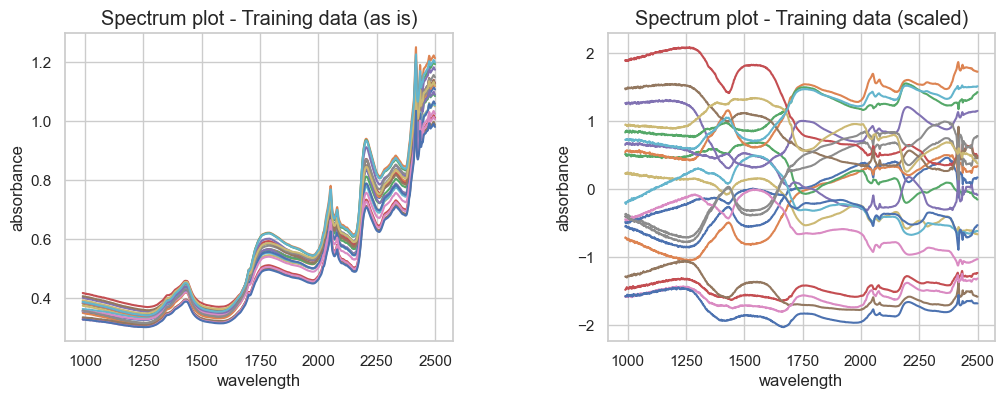

In [32]:
from sklearn.model_selection import cross_val_predict, train_test_split, KFold, StratifiedKFold, RepeatedKFold

# This dataset has 4 different label columns. We can select any one for our research
y_data_columns = ['IVOMD', 'IVDMD', 'NDF', 'ADF']

# Nothing to change here.
split_params = {
    'drop_columns' : y_data_columns,
    'index_column' : None,
}

# Data splitting can be done in various proportions. Check proportions of train-test values available in configfile.ini file

X = dataframe.drop(axis=1,columns=split_params['drop_columns'])  # drop the y column
y = dataframe[y_data_columns[0]]
data = X_train, X_test, y_train, y_test = tuple(train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True))

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train,
    'title':'Spectrum plot - Training data (as is)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_scaled,
    'title':'Spectrum plot - Training data (scaled)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

<h3 style="color: #eeaf23">Pre-processor 1 (Scaling + Derivative)</h3>

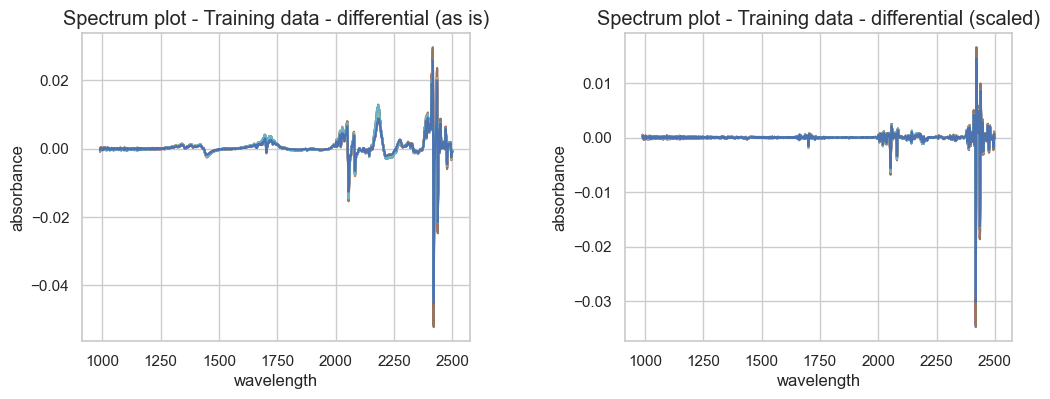

In [15]:
X_train_diff = np.gradient(X_train, axis=1)
X_train_diff_scaled = np.gradient(X_train_diff, axis=1)

plot1_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_diff,
    'title':'Spectrum plot - Training data - differential (as is)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
plot2_params = {
    'x_axis_data' : wl,
    'y_axis_data': X_train_diff_scaled,
    'title':'Spectrum plot - Training data - differential (scaled)',
    'xlabel':'wavelength',
    'ylabel':'absorbance'
}
util.dual_plot(plot1_params,plot2_params)

<h3 style="color: #eeaf23">Pre-processor 2 (Derivative 0,1,2 + Smoothing)</h3>

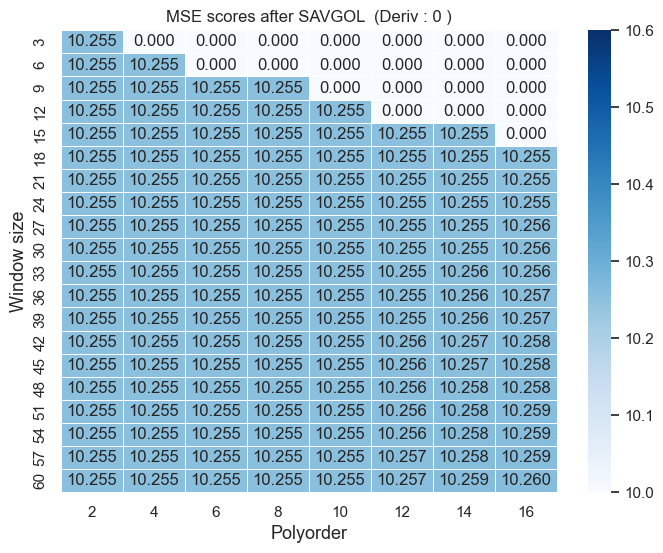

Least MSE from SAVGOL loop run 10.25515089570027
Best window size 60
Best polyorder 10


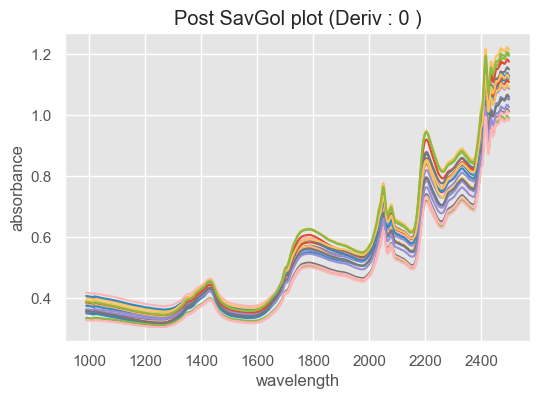

In [16]:
# SAVGOL + Deriv 0

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 0

X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=True)

# PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
print("Best window size {}".format(best_window_size))
print("Best polyorder {}".format(best_polyorder))

util.plot(x_axis_data=wl, y_axis_data=X_train_preprocessed,
     title='Post SavGol plot (Deriv : ' + str(derivative) + ' )', xlabel='wavelength',
     ylabel='absorbance')

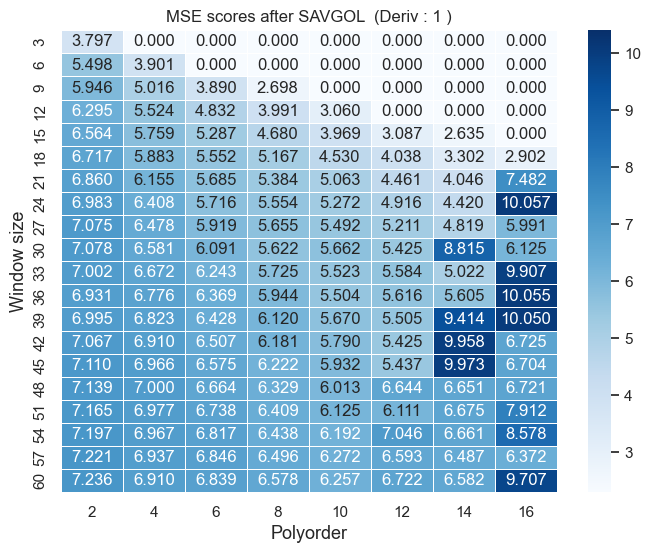

Least MSE from SAVGOL loop run 2.6345920162862506
Best window size 15
Best polyorder 14


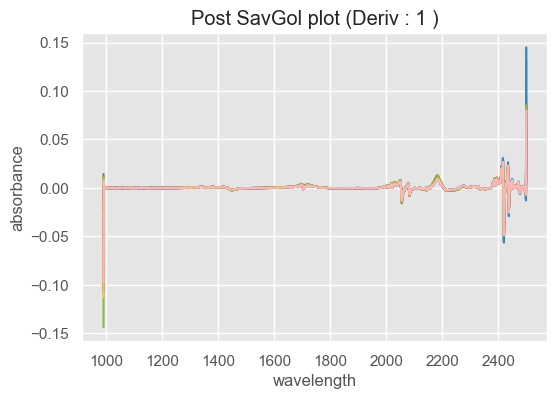

In [17]:
# SAVGOL + Deriv 1

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 1

X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=True)

# PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
print("Best window size {}".format(best_window_size))
print("Best polyorder {}".format(best_polyorder))

util.plot(x_axis_data=wl, y_axis_data=X_train_preprocessed,
     title='Post SavGol plot (Deriv : ' + str(derivative) + ' )', xlabel='wavelength',
     ylabel='absorbance')

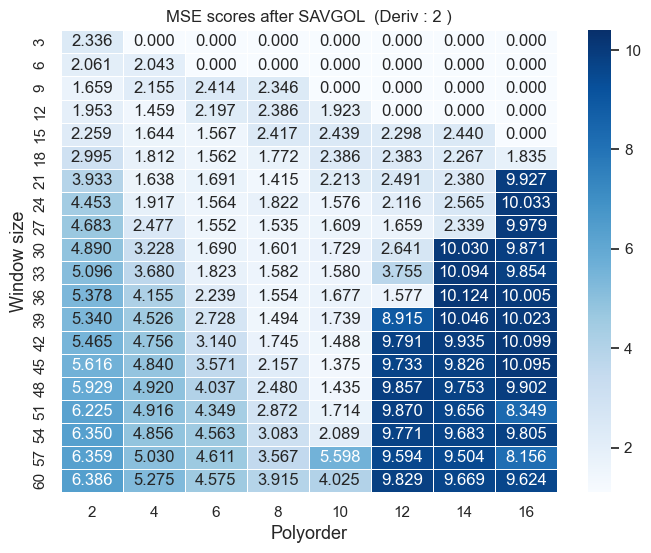

Least MSE from SAVGOL loop run 1.375427016073821
Best window size 45
Best polyorder 10


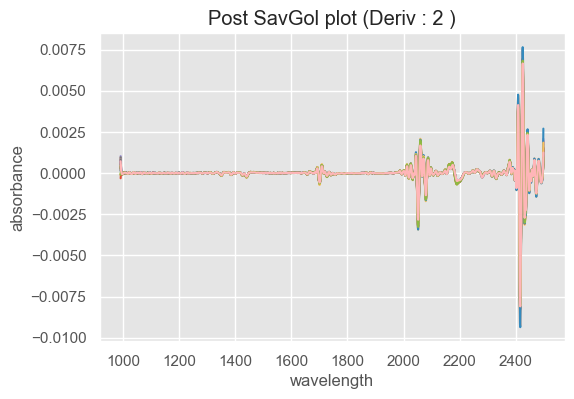

In [18]:
# SAVGOL + Deriv 2

window_range = np.arange(3,63,3)
polyorder_range = np.arange(2,18,2)
derivative = 2

X_train_preprocessed, X_test_preprocessed, least_mse_score, best_window_size, best_polyorder = \
    util.savgol(data, window_size_range=window_range,
           polyorder_range=polyorder_range,
           deriv=derivative, showPlot=True)

# PRINT LEAST MSE_SCORE VALUE, BEST WINDOW_SIZE AND BEST POLYNOMIAL
print("Least MSE from SAVGOL loop run {}".format(least_mse_score))
print("Best window size {}".format(best_window_size))
print("Best polyorder {}".format(best_polyorder))

util.plot(x_axis_data=wl, y_axis_data=X_train_preprocessed,
     title='Post SavGol plot (Deriv : ' + str(derivative) + ' )', xlabel='wavelength',
     ylabel='absorbance')

<h3 style="color: #eeaf23">Pre-processor 3 (Scatter Correction)</h3>

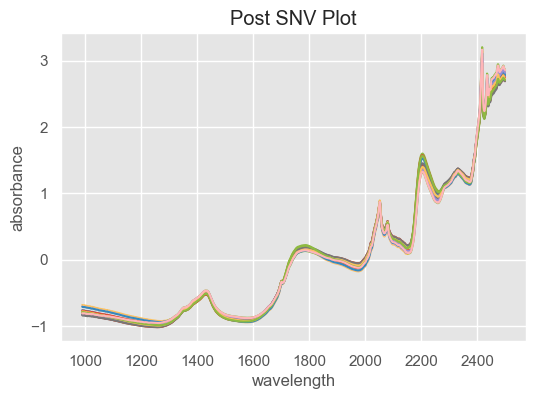

In [19]:
# SNV
X_train_snv, X_test_snv = util.snv(data)

# Plot for SNV
util.plot(wl, X_train_snv, title='Post SNV Plot', xlabel='wavelength', ylabel='absorbance')

<h3 style="color: #eeaf23">Only preprocessing</h3>

INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : Animal Feed Dataset , Preprocessor : savgol0, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]


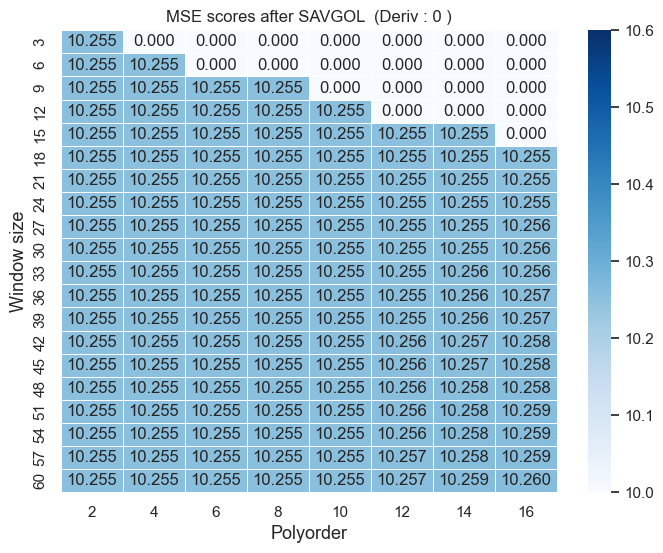

INFO Least MSE from SAVGOL loop run 10.25515089570027
INFO Best window size 60
INFO Best polyorder 10


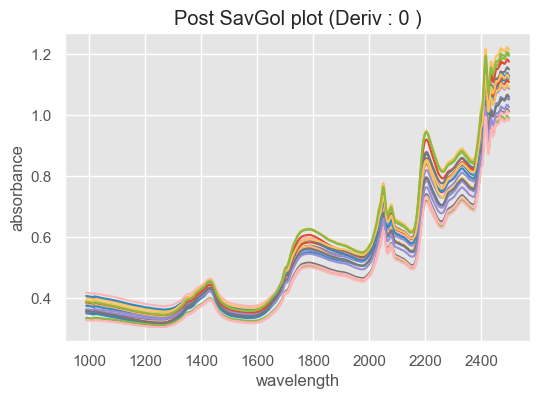

INFO Elapsed time for pipeline run : 1.93
INFO Pipeline end...
INFO ************************************
INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : Animal Feed Dataset , Preprocessor : savgol1, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]


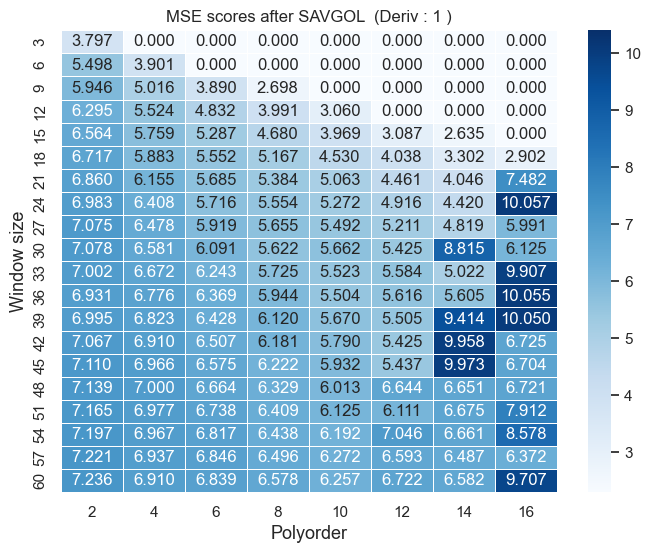

INFO Least MSE from SAVGOL loop run 2.6345920162862506
INFO Best window size 15
INFO Best polyorder 14


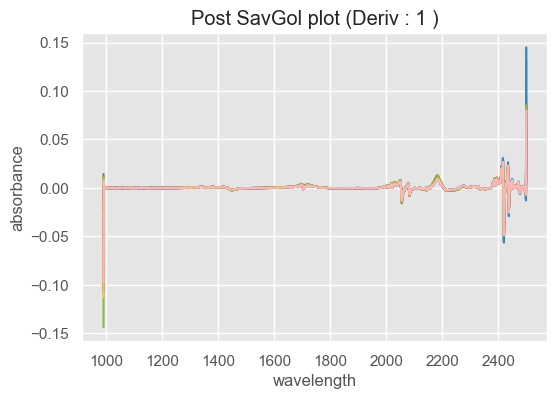

INFO Elapsed time for pipeline run : 1.2
INFO Pipeline end...
INFO ************************************
INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : Animal Feed Dataset , Preprocessor : savgol2, Model : pls, Evaluator : mse
INFO Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]


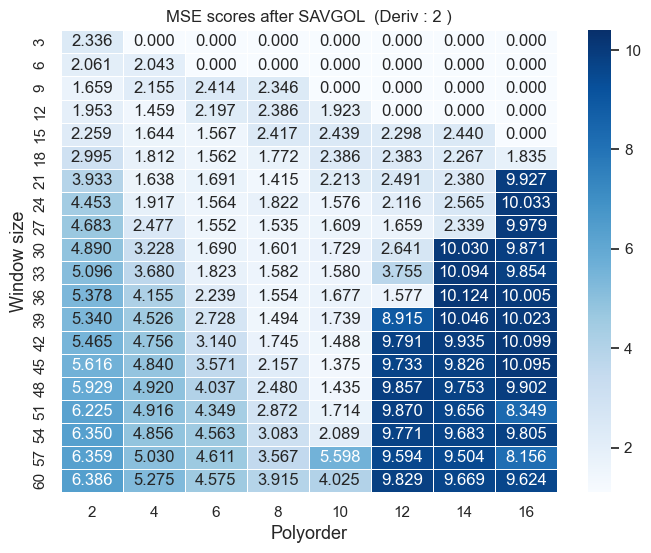

INFO Least MSE from SAVGOL loop run 1.375427016073821
INFO Best window size 45
INFO Best polyorder 10


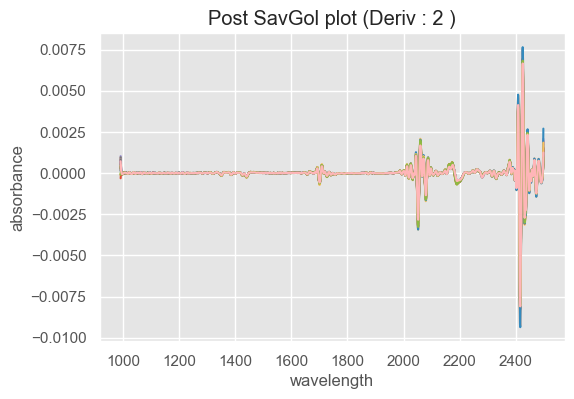

INFO Elapsed time for pipeline run : 1.03
INFO Pipeline end...
INFO ************************************


In [84]:
for index, val in enumerate(preprocessors):
    if index in [0,1,2]:     # selecting only the required preprocessors

        # Ideally not required to change anything here.
        # But you can change the derivative explicitly as per your choice (0,1 or 2)
        preprocessor_params = {
            'savgol' : {
                'window_size_range' : np.arange(3,63,3),
                'polyorder_range' : np.arange(2,18,2),
                'derivative' : index
            }
        }

        # Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
        # Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
        # Set models[0] for PLS and models[1] for LASSO
        # evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
        # preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
        # preprocessor-params: only required for SavGol and its related combos.
        # pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
        pipeline_params = {
            'logger' : logger,
            'data' : data,
            'validation-type' : validation_types[0],
            'preprocessor' : val,
            'preprocessor-params' : preprocessor_params,
            'model' : models[0],
            'evaluator' : evaluators[0],
            'pls_max_n_comp' : int(pls_max_n_comp),
            'folds' : int(folds),
            'wl' : wl,
            'plotting' : True,
            'showModelEvaluationPlots' : True,
            'pipeline_run_type' : pipeline_run_types[0]
        }

        start = timer()
        logger.info("************************************")
        logger.info("Pipeline Start...")
        logger.info("Pipeline params :")
        logger.info("Data : Animal Feed Dataset" + " , Preprocessor : " + str(pipeline_params['preprocessor'])
                    + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
        logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", PLS max n_comp : "
                    + str(pipeline_params['pls_max_n_comp']) + ", folds (for CV) : " + str(pipeline_params['folds']))
        util.pipeline(pipeline_params)
        end = timer()
        logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
        logger.info("Pipeline end...")
        logger.info("************************************")

<h3 style="color: #eeaf23">Running PLSR pipeline</h3>

In [24]:
# Run pipeline in loop for all preprocessors combinations OR
# For selected preprocessors only, you can run the loop using a slice from the whole preprocessors list variable.
# To check which slice you want, check the configfile.ini file
for index, val in enumerate(preprocessors):
    if index in [1, 3, 11]:
        derivative = 1

        # Ideally not required to change anything here.
        # But you can change the derivative explicitly as per your choice (0,1 or 2)
        preprocessor_params = {
            'savgol' : {
                'window_size_range' : np.arange(3,63,3),
                'polyorder_range' : np.arange(2,18,2),
                'derivative' : derivative
            }
        }

        # Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
        # Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
        # Set models[0] for PLS and models[1] for LASSO
        # evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
        # preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
        # preprocessor-params: only required for SavGol and its related combos.
        # pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
        pipeline_params = {
            'logger' : logger,
            'data' : data,
            'validation-type' : validation_types[0],
            'preprocessor' : val,
            'preprocessor-params' : preprocessor_params,
            'model' : models[0],
            'evaluator' : evaluators[0],
            'pls_max_n_comp' : int(pls_max_n_comp),
            'folds' : int(folds),
            'wl' : wl,
            'plotting' : False,
            'showModelEvaluationPlots' : False,
            'pipeline_run_type' : pipeline_run_types[1]
        }

        start = timer()
        logger.info("Pipeline Start...")
        logger.info("Parameters :")
        params = "Data : Animal Feed data" + " , Preprocessor : " + str(pipeline_params['preprocessor']) + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']) + ", Validation type : " + str(pipeline_params['validation-type']) + ", PLS max n_comp : " + str(pipeline_params['pls_max_n_comp']) + ", folds (for CV) : " + str(pipeline_params['folds'])
        logger.info(params)
        util.pipeline(pipeline_params)
        end = timer()
        logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
        logger.info("Pipeline end...")
        logger.info("************************************")


INFO Pipeline Start...
INFO Parameters :
INFO Data : Animal Feed data , Preprocessor : savgol1, Model : pls, Evaluator : mse, Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Least MSE from SAVGOL loop run 0.17889203671922707
INFO Best window size 15
INFO Best polyorder 14
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 4
INFO [MODEL EVALUATION]
INFO Model loss : 0.989454687779659
INFO Elapsed time for pipeline run : 3.33
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : Animal Feed data , Preprocessor : snv, Model : pls, Evaluator : mse, Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]




[Model Evaluation] MSE value between y_test and y_pred : 0.989


INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 9
INFO [MODEL EVALUATION]
INFO Model loss : 1.0264308427532856




[Model Evaluation] MSE value between y_test and y_pred : 1.026


INFO Elapsed time for pipeline run : 2.29
INFO Pipeline end...
INFO ************************************
INFO Pipeline Start...
INFO Parameters :
INFO Data : Animal Feed data , Preprocessor : derivative, Model : pls, Evaluator : mse, Validation type : kfold-cv, PLS max n_comp : 40, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER (N_COMP) TUNING]


100% Validation completed 

INFO Optimized n_comp for PLS 17
INFO [MODEL EVALUATION]
INFO Model loss : 0.9056192549002766
INFO Elapsed time for pipeline run : 1.95




[Model Evaluation] MSE value between y_test and y_pred : 0.906


INFO Pipeline end...
INFO ************************************


R-squared score: 0.258083048916409
Mean Squared Error: 11.761219919128859
R-squared score with differential: 0.19108723550134443
Mean Squared Error with differential: 12.823269376395835


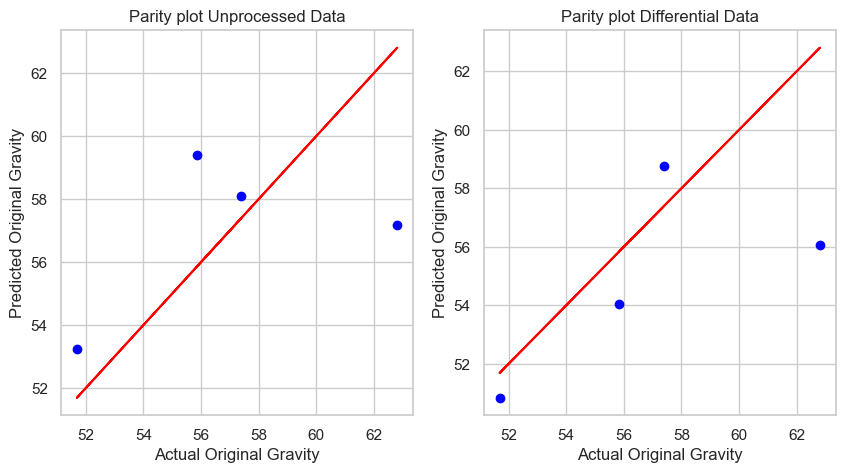

In [83]:
# Setting up the data with preprocessors
X_train_diff = np.gradient(X_train, axis=1)
X_test_diff = np.gradient(X_test, axis=1)

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Fitting the PLS model with unprocessed data
pls = PLSRegression(n_components=2)
pls.fit(X_train, y_train)
# Predicting the test set results
y_pred = pls.predict(X_test)

# Fitting the PLS model with differential data
pls = PLSRegression(n_components=2)
pls.fit(X_train_diff, y_train)
# Predicting the test set results
y_pred_diff = pls.predict(X_test_diff)

# Calculating the R-squared score
r2 = r2_score(y_test, y_pred)
r2_diff = r2_score(y_test, y_pred_diff)

mse = mean_squared_error(y_test, y_pred)
mse_diff = mean_squared_error(y_test, y_pred_diff)

print('R-squared score:', r2)
print('Mean Squared Error:', mse)

print('R-squared score with differential:', r2_diff)
print('Mean Squared Error with differential:', mse_diff)


import matplotlib.pyplot as plt
fig4 = plt.figure(figsize=(10, 5))

# Plot spectra as is
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot Unprocessed Data')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred_diff, color='blue')
plt.plot(y_test, y_test, color='red')
plt.title('Parity plot Differential Data')
plt.xlabel('Actual Original Gravity')
plt.ylabel('Predicted Original Gravity')
plt.show()

<h3 style="color: #eeaf23">Running LASSO pipeline</h3>

In [26]:
# Not required since we use only SNV and MSC for LASSO
preprocessor_params = {
    'savgol' : {
                'window_size_range' : np.arange(3,63,3),
                'polyorder_range' : np.arange(2,18,2),
                'derivative' : 1
            }
}

# Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
# Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
# Set models[0] for PLS and models[1] for LASSO
# evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
# preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
# preprocessor-params: only required for SavGol and its related combos.
# pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
pipeline_params = {
    'logger' : logger,
    'data' : data,
    'validation-type' : validation_types[0],
    'preprocessor' : preprocessors[11],              # set 3 for SNV and 11 for Deriv1
    'preprocessor-params' : preprocessor_params,
    'model' : models[1],
    'evaluator' : evaluators[0],
    'alpha_range' : alpha_range,
    'pls_max_n_comp' : int(pls_max_n_comp),
    'folds' : int(folds),
    'wl' : wl,
    'plotting' : False,
    'showModelEvaluationPlots' : False,
    'pipeline_run_type' : pipeline_run_types[1]
}

start = timer()
logger.info("************************************")
logger.info("Pipeline Start...")
logger.info("Pipeline params :")
logger.info("Data : Animal Dataset" + " , Preprocessor : " + str(pipeline_params['preprocessor'])
            + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", folds (for CV) : " + str(pipeline_params['folds']))
util.pipeline(pipeline_params)
end = timer()
logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
logger.info("Pipeline end...")
logger.info("************************************")

INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : Animal Dataset , Preprocessor : derivative, Model : lasso, Evaluator : mse
INFO Validation type : kfold-cv, folds (for CV) : 5
INFO [VALIDATION AND HYPERPARAMETER (Alpha value) TUNING]


[Model Evaluation] MSE value between y_test and y_pred : 0.737
[Model Evaluation] MSE value between y_test and y_pred after pre-processing : 0.737


INFO Optimized alpha value for Lasso 7.277757842363929e-05
INFO [MODEL EVALUATION]
INFO Model loss : 1.1484322656244759
INFO Elapsed time for pipeline run : 16.69
INFO Pipeline end...
INFO ************************************


<h3 style="color: #eeaf23">Running RF pipeline</h3>

In [28]:
# Used only in case of SavGol1
preprocessor_params = {
    'savgol' : {
                'window_size_range' : np.arange(3,63,3),
                'polyorder_range' : np.arange(2,18,2),
                'derivative' : 1
            }
}

# Define the parameter grid for grid search CV
param_grid = {'n_estimators': [50, 100, 200],
              'max_depth': [5, 10, 20, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['auto', 'sqrt']}

# Set plotting:True for showing all plots (preprocessing, model fitting, etc. everything)
# Set showModelEvaluationPlots:True specifically to show final model evaluation and line of best fit plots. IDEALLY MUST BE SET TO True
# Set models[0] for PLS, models[1] for LASSO, models[2] for RandomForests
# evaluators[0] means MSE. Nothing to change here because MSE is best for regression model evaluation
# preprocessor: preprocessor[index] where index is (0,...,10). Here since it's running in loop, it gets from val.
# preprocessor-params: only required for SavGol and its related combos.
# pipeline_run_type: pipeline_run_types[index] -> index can be 0 or 1. 0 means only until preprocessing, 1 means total.
pipeline_params = {
    'logger' : logger,
    'data' : data,
    'validation-type' : validation_types[3],     # FIXED to Grid Search CV
    'preprocessor' : preprocessors[11],              # set 11 for derivative, 3 for SNV
    'preprocessor-params' : preprocessor_params,
    'model' : models[2],
    'evaluator' : evaluators[0],
    'folds' : int(folds),
    'wl' : wl,
    'plotting' : False,
    'showModelEvaluationPlots' : False,
    'pipeline_run_type' : pipeline_run_types[1],
    'param_grid' : param_grid
}

start = timer()
logger.info("************************************")
logger.info("Pipeline Start...")
logger.info("Pipeline params :")
logger.info("Data : Animal Feed" + " , Preprocessor : " + str(pipeline_params['preprocessor'])
            + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", folds (for CV) : " + str(pipeline_params['folds']))
util.pipeline(pipeline_params)
end = timer()
logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
logger.info("Pipeline end...")
logger.info("************************************")

INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : Animal Feed , Preprocessor : derivative, Model : randomforests, Evaluator : mse
INFO Validation type : grid-search-cv, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO [VALIDATION AND HYPERPARAMETER TUNING]
INFO Optimized hyper-params for RandomForests {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
INFO [MODEL EVALUATION]


R-squared score: -0.6619853457146767
Mean Squared Error: 0.8378379750000008
Model Performance
Average Error: 0.8479 degrees.
Accuracy = 94.95%.


ValueError: data type <class 'numpy.object_'> not inexact

<h3 style="color: #eeaf23">Running SVR pipeline</h3>

In [35]:
# Used only in case of SavGol1
preprocessor_params = {
    'savgol' : {
                'window_size_range' : np.arange(3,63,3),
                'polyorder_range' : np.arange(2,18,2),
                'derivative' : 1
            }
}

# Define custom param_grid for Grid Search CV
param_grid = {
    'kernel': ['poly'],
    'C': [50, 100],
    'epsilon': [0.1]
}

pipeline_params = {
    'logger' : logger,
    'data' : data,
    'validation-type' : validation_types[0],     # not required here
    'preprocessor' : preprocessors[1],              # set 1 for SavGol 1, 3 for SNV, 11 for derivative
    'preprocessor-params' : preprocessor_params,
    'model' : models[3],
    'evaluator' : evaluators[0],
    'folds' : int(folds),
    'wl' : wl,
    'plotting' : False,
    'showModelEvaluationPlots' : True,
    'pipeline_run_type' : pipeline_run_types[1],
    'param_grid': param_grid
}

start = timer()
logger.info("************************************")
logger.info("Pipeline Start...")
logger.info("Pipeline params :")
logger.info("Data : Animal Feed " + " , Preprocessor : " + str(pipeline_params['preprocessor'])
            + ", Model : " + str(pipeline_params['model']) + ", Evaluator : " + str(pipeline_params['evaluator']))
logger.info("Validation type : " + str(pipeline_params['validation-type']) + ", folds (for CV) : " + str(pipeline_params['folds']))
util.pipeline(pipeline_params)
end = timer()
logger.info("Elapsed time for pipeline run : " + str(round((end - start),2)))
logger.info("Pipeline end...")
logger.info("************************************")

INFO ************************************
INFO Pipeline Start...
INFO Pipeline params :
INFO Data : Animal Feed  , Preprocessor : savgol1, Model : svr, Evaluator : mse
INFO Validation type : kfold-cv, folds (for CV) : 5
INFO [PRE PROCESSING]
INFO Least MSE from SAVGOL loop run 2.6345920162862506
INFO Best window size 15
INFO Best polyorder 14
INFO [VALIDATION AND HYPERPARAMETER TUNING]


R-squared score: -0.07702390201006937
Mean Squared Error: 17.07349448101709
Model Performance
Average Error: 3.1750 degrees.
Accuracy = 94.53%.


ValueError: data type <class 'numpy.object_'> not inexact